### Imports

In [1]:
# Imports
import numpy as np # math

from astropy.table import Table # Reading and storing the data tables
from astropy.coordinates import SkyCoord # crossmatching coordinates
from astropy.cosmology import Planck18 as cosmo # cosmology for luminosity distance

import astropy.units as u # units and stuffs

import matplotlib.pyplot as plt # plots


# Loading Data

## eRASS1

Load in and check structure of the eRASS1 main source catalogue. <br>
Available to download from [here (ID 1)](https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/).

In [2]:
eRASS_sources_full = Table.read("../Data/eRASS1_Main.v1.1.fits", format='fits')
print(len(eRASS_sources_full), "Sources")
eRASS_sources_full[0:3]


930203 Sources


IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,DET_LIKE_P1,ML_CTS_P1,ML_CTS_ERR_P1,ML_CTS_LOWERR_P1,ML_CTS_UPERR_P1,ML_RATE_P1,ML_RATE_ERR_P1,ML_RATE_LOWERR_P1,ML_RATE_UPERR_P1,ML_FLUX_P1,ML_FLUX_ERR_P1,ML_FLUX_LOWERR_P1,ML_FLUX_UPERR_P1,ML_BKG_P1,ML_EXP_P1,ML_EEF_P1,APE_CTS_P1,APE_BKG_P1,APE_EXP_P1,APE_RADIUS_P1,APE_POIS_P1,DET_LIKE_P2,ML_CTS_P2,ML_CTS_ERR_P2,ML_CTS_LOWERR_P2,ML_CTS_UPERR_P2,ML_RATE_P2,ML_RATE_ERR_P2,ML_RATE_LOWERR_P2,ML_RATE_UPERR_P2,ML_FLUX_P2,ML_FLUX_ERR_P2,ML_FLUX_LOWERR_P2,ML_FLUX_UPERR_P2,ML_BKG_P2,ML_EXP_P2,ML_EEF_P2,APE_CTS_P2,APE_BKG_P2,APE_EXP_P2,APE_RADIUS_P2,APE_POIS_P2,DET_LIKE_P3,ML_CTS_P3,ML_CTS_ERR_P3,ML_CTS_LOWERR_P3,ML_CTS_UPERR_P3,ML_RATE_P3,ML_RATE_ERR_P3,ML_RATE_LOWERR_P3,ML_RATE_UPERR_P3,ML_FLUX_P3,ML_FLUX_ERR_P3,ML_FLUX_LOWERR_P3,ML_FLUX_UPERR_P3,ML_BKG_P3,ML_EXP_P3,ML_EEF_P3,APE_CTS_P3,APE_BKG_P3,APE_EXP_P3,APE_RADIUS_P3,APE_POIS_P3,DET_LIKE_P4,ML_CTS_P4,ML_CTS_ERR_P4,ML_CTS_LOWERR_P4,ML_CTS_UPERR_P4,ML_RATE_P4,ML_RATE_ERR_P4,ML_RATE_LOWERR_P4,ML_RATE_UPERR_P4,ML_FLUX_P4,ML_FLUX_ERR_P4,ML_FLUX_LOWERR_P4,ML_FLUX_UPERR_P4,ML_BKG_P4,ML_EXP_P4,ML_EEF_P4,APE_CTS_P4,APE_BKG_P4,APE_EXP_P4,APE_RADIUS_P4,APE_POIS_P4,DET_LIKE_P5,ML_CTS_P5,ML_CTS_ERR_P5,ML_CTS_LOWERR_P5,ML_CTS_UPERR_P5,ML_RATE_P5,ML_RATE_ERR_P5,ML_RATE_LOWERR_P5,ML_RATE_UPERR_P5,ML_FLUX_P5,ML_FLUX_ERR_P5,ML_FLUX_LOWERR_P5,ML_FLUX_UPERR_P5,ML_BKG_P5,ML_EXP_P5,ML_EEF_P5,APE_CTS_P5,APE_BKG_P5,APE_EXP_P5,APE_RADIUS_P5,APE_POIS_P5,DET_LIKE_P6,ML_CTS_P6,ML_CTS_ERR_P6,ML_CTS_LOWERR_P6,ML_CTS_UPERR_P6,ML_RATE_P6,ML_RATE_ERR_P6,ML_RATE_LOWERR_P6,ML_RATE_UPERR_P6,ML_FLUX_P6,ML_FLUX_ERR_P6,ML_FLUX_LOWERR_P6,ML_FLUX_UPERR_P6,ML_BKG_P6,ML_EXP_P6,ML_EEF_P6,APE_CTS_P6,APE_BKG_P6,APE_EXP_P6,APE_RADIUS_P6,APE_POIS_P6,DET_LIKE_P7,ML_CTS_P7,ML_CTS_ERR_P7,ML_CTS_LOWERR_P7,ML_CTS_UPERR_P7,ML_RATE_P7,ML_RATE_ERR_P7,ML_RATE_LOWERR_P7,ML_RATE_UPERR_P7,ML_FLUX_P7,ML_FLUX_ERR_P7,ML_FLUX_LOWERR_P7,ML_FLUX_UPERR_P7,ML_BKG_P7,ML_EXP_P7,ML_EEF_P7,APE_CTS_P7,APE_BKG_P7,APE_EXP_P7,APE_RADIUS_P7,APE_POIS_P7,DET_LIKE_P8,ML_CTS_P8,ML_CTS_ERR_P8,ML_CTS_LOWERR_P8,ML_CTS_UPERR_P8,ML_RATE_P8,ML_RATE_ERR_P8,ML_RATE_LOWERR_P8,ML_RATE_UPERR_P8,ML_FLUX_P8,ML_FLUX_ERR_P8,ML_FLUX_LOWERR_P8,ML_FLUX_UPERR_P8,ML_BKG_P8,ML_EXP_P8,ML_EEF_P8,APE_CTS_P8,APE_BKG_P8,APE_EXP_P8,APE_RADIUS_P8,APE_POIS_P8,DET_LIKE_P9,ML_CTS_P9,ML_CTS_ERR_P9,ML_CTS_LOWERR_P9,ML_CTS_UPERR_P9,ML_RATE_P9,ML_RATE_ERR_P9,ML_RATE_LOWERR_P9,ML_RATE_UPERR_P9,ML_FLUX_P9,ML_FLUX_ERR_P9,ML_FLUX_LOWERR_P9,ML_FLUX_UPERR_P9,ML_BKG_P9,ML_EXP_P9,ML_EEF_P9,APE_CTS_P9,APE_BKG_P9,APE_EXP_P9,APE_RADIUS_P9,APE_POIS_P9,APE_CTS_S,APE_BKG_S,APE_EXP_S,APE_POIS_S,FLAG_SP_SNR,FLAG_SP_BPS,FLAG_SP_SCL,FLAG_SP_LGA,FLAG_SP_GC_CONS,FLAG_NO_RADEC_ERR,FLAG_NO_EXT_ERR,FLAG_NO_CTS_ERR,FLAG_OPT
,,,,,,,deg,deg,deg,deg,arcsec,arcsec,arcsec,arcsec,,,deg,deg,deg,deg,d,d,d,arcsec,arcsec,arcsec,arcsec,,,ct,ct,ct,ct,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),1 / arcmin2,s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),1 / arcmin2,s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),1 / arcmin2,s,,,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),1 / arcmin2,s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),1 / arcmin2,s,,ct,ct,s,pix,,,ct,c

Select the columns I will require so it is easier to use table.<br>

- IAUNAME
- UID
- RA
- DEC
- RADEC_ERR
- EXT
- ML_FLUX_1


Will also select point source (`EXT == 0`)


In [3]:
eRASS_sources = eRASS_sources_full['IAUNAME', 'UID', 'RA', 'DEC', 'RADEC_ERR', 'EXT', 'ML_FLUX_1']
eRASS_sources = eRASS_sources[eRASS_sources['EXT']== 0]
print(len(eRASS_sources), "Point Sources")
eRASS_sources[0:5]


903521 Point Sources


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1
,,deg,deg,,arcsec,erg / (s cm2)
bytes23,int64,float64,float64,float32,float32,float32
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693,0.0,1.5508955e-12
1eRASS J005448.9-311230,101212000004,13.70410463883818,-31.208436362171515,1.652596,0.0,6.9885916e-13
1eRASS J012910.8-214156,102111100001,22.295164764919686,-21.698997556091005,0.62720245,0.0,3.4790614e-12
1eRASS J012338.1-231059,102111400001,20.90908484230626,-23.183134713205,1.2023203,0.0,1.1919693e-11
1eRASS J015219.0-183235,102710800003,28.079291921052764,-18.543088853166505,1.3169006,0.0,8.0001153e-13


## GAIA QSOs

Gaia data from [gaia archive](https://gea.esac.esa.int/archive/) using the follow Query:<br>
```SQL
SELECT g.source_id, g.ra, g.dec, g.pm, qs.gaia_crf_source,
qs.host_galaxy_flag, qs.classprob_dsc_combmod_quasar,
qs.classlabel_dsc_joint, qs.vari_best_class_name, qs.redshift_qsoc
FROM gaiadr3.qso_candidates as qs
JOIN gaiadr3.gaia_source as g
USING (solution_id, source_id)
WHERE (qs.gaia_crf_source='true' OR qs.host_galaxy_flag<6
OR qs.classlabel_dsc_joint='quasar' OR qs.vari_best_class_name='AGN')
```
<br>

This query is based on the one listed in [Table 11 of the GAIA DR3 extragalactic paper](https://doi.org/10.1051/0004-6361/202243232)

In [4]:
gaia_qso_sources = Table.read("../Data/GAIA_Quasars_Full.csv")
print(len(gaia_qso_sources), "Sources")
gaia_qso_sources[0:3]


1942825 Sources


source_id,ra,dec,pm,gaia_crf_source,host_galaxy_flag,classprob_dsc_combmod_quasar,classlabel_dsc_joint,vari_best_class_name,redshift_qsoc
int64,float64,float64,float64,str5,int64,float64,str12,str15,float64
4152040546849964288,269.42343013804424,-11.250076967522755,1.1517469,true,--,1.2516455e-07,unclassified,--,--
5939392802025441152,252.6345739540496,-47.708030634186045,1.6419761,false,3,2.2428847e-07,unclassified,SYST,--
5939534600358282880,250.96523522423945,-47.670558949993385,2.3291168,false,3,0.00018701961,unclassified,--,--


Many of these sources do not have redshift so remove these and also only select required columns

- source_id
- ra
- dec
- redshift_qsoc

In [5]:
gaia_qso_sources = gaia_qso_sources[~np.isnan(gaia_qso_sources['redshift_qsoc']).mask]
gaia_qso_sources = gaia_qso_sources['source_id', 'ra', 'dec', 'redshift_qsoc']
print(len(gaia_qso_sources), "Sources with redshifts")
gaia_qso_sources[0:5]


1729625 Sources with redshifts


source_id,ra,dec,redshift_qsoc
int64,float64,float64,float64
5823582960248697728,230.7076929999774,-67.69752390372247,2.491088
5823596601041876736,230.68012821621508,-67.6218345443544,0.15514289
5823630514109745664,231.10371480375875,-67.28434173231645,0.74870634
5823637111177947520,231.06011701973114,-67.10952092968711,0.09709132
5823659754273471872,230.6431087626876,-67.14305101603547,3.3342328


### Purer GAIA Quasars

Basically same as normal gaia except with `AND` instead of `OR`.
Not sure if this will actually be cleaner, but I thought it was strange than many were labeled as `"unclassified"`


In [6]:
purer_gaia_sources = Table.read("../Data/purer_GAIA_Quasars.csv")
print(len(purer_gaia_sources), "Quasar Sources")
## Don't need to check for redshifts since all have redshifts
# purer_gaia_sources = purer_gaia_sources[~np.isnan(purer_gaia_sources['redshift_qsoc']).mask]
purer_gaia_sources = purer_gaia_sources['source_id', 'ra', 'dec', 'redshift_qsoc']
purer_gaia_sources[0:3]


214104 Quasar Sources


source_id,ra,dec,redshift_qsoc
int64,float64,float64,float64
6653810339087893504,273.6394413022079,-53.20260279604084,1.7522463
6836620846036858880,327.1195114093446,-18.471707923850712,1.5499382
6836649089741920384,327.5054348897559,-18.33581567293887,1.9532677


## Quaia Quasars

Quaia is an all-sky quasar catalog from combining Gaia and unWISE that should be more pure and better redshifts than the default Gaia catalog.<br>
The paper describing it and a link to the catalog can be [found here](https://doi.org/10.48550/arXiv.2306.17749)

In [7]:
quaia_sources = Table.read("../Data/quaia_G20.0.fits")
print(len(quaia_sources), "Quaia Quasars")
quaia_sources[0:3]


755850 Quaia Quasars


source_id,unwise_objid,redshift_quaia,redshift_quaia_err,ra,dec,l,b,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,mag_w1_vg,mag_w2_vg,pm,pmra,pmdec,pmra_error,pmdec_error
,,,,deg,deg,deg,deg,mag,mag,mag,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr
int64,bytes16,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32
10892037246720,0453p000o0015876,1.7364680767059326,0.09870262884140013,45.18857525358218,0.28242442525431893,176.85154355262011,-48.5708559360798,18.78724,19.080688,18.240915,15.21995,13.868094,0.15540553490476286,-0.09803741741546984,-0.12058003593273806,0.257395,0.22310686
15839839588736,0453p000o0017020,1.5130492448806763,0.07810206890106197,45.189480360571665,0.3591947400894022,176.76912910053676,-48.51684235773577,18.888464,19.17128,18.50937,15.317786,14.013617,0.44892476891575755,-0.31608849256513893,0.31878129338774636,0.36059502,0.3265819
22780506725760,0453p000o0016209,2.852853775024414,0.07791999999999999,44.79936522932521,0.30355729158111383,176.4176643816323,-48.83530904204095,19.218422,19.48634,18.8145,16.027142,15.041919,0.5232111830158942,0.16823689536016173,0.495425361757415,0.36143935,0.269473


Select required columns<br>
- source_id (this is same as gaia source_id)
- redshift_quaia
- redshift_quaia_err
- ra
- dec
- I think that was it...

In [8]:
quaia_sources = quaia_sources['source_id', 'redshift_quaia', 'redshift_quaia_err', 'ra', 'dec']
quaia_sources[0:5]


source_id,redshift_quaia,redshift_quaia_err,ra,dec
,,,deg,deg
int64,float64,float64,float64,float64
10892037246720,1.7364680767059326,0.09870262884140013,45.18857525358218,0.28242442525431893
15839839588736,1.5130492448806763,0.07810206890106197,45.189480360571665,0.3591947400894022
22780506725760,2.852853775024414,0.07791999999999999,44.79936522932521,0.30355729158111383
29102698617216,1.7234398126602173,0.5431374826049805,45.07952191471843,0.43963647300547504
35115652874752,0.803479790687561,0.07041599310874941,44.99106740350177,0.5817285409510972


# Crossmatching

For now, will just use a cut off separation of 3 arcsecs

In [9]:
gaia_coords = SkyCoord(ra=gaia_qso_sources['ra']*u.deg, dec=gaia_qso_sources['dec']*u.deg)
eRASS_coords = SkyCoord(ra=eRASS_sources['RA'], dec=eRASS_sources['DEC']) # eRASS data has units on it coordinates 😀

ids, d2d, d3d = eRASS_coords.match_to_catalog_sky(gaia_coords)

max_separation = u.Quantity(3,"arcsec")
separation_condition = d2d < max_separation

print(np.count_nonzero(separation_condition), "matches within 3 arcsec")


63211 matches within 3 arcsec


Histogram of the distribution of separations.

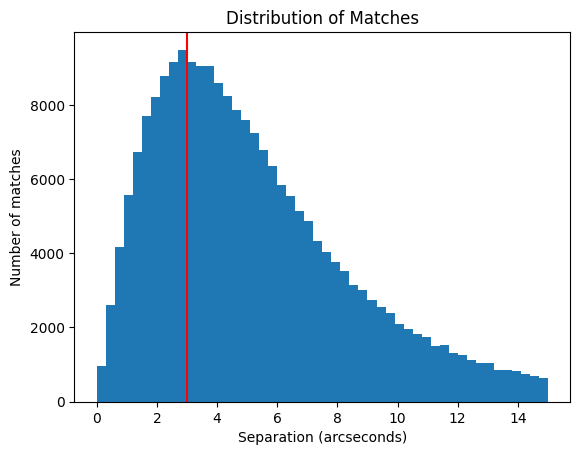

In [10]:
plt.figure(dpi=100)
counts, bins, *_ = plt.hist(d2d.arcsec[d2d < u.Quantity(15, "arcsec")], bins=50)

plt.axvline(max_separation.value, c='r')
plt.ylabel("Number of matches")
plt.xlabel("Separation (arcseconds)")
plt.title("Distribution of Matches")
plt.savefig("../Products/matching_distribution.png")
plt.show()


Create new Table with matched Quasars

In [11]:
matched_quasars = eRASS_sources[separation_condition]
matched_quasars['GAIA_source_id'] = gaia_qso_sources[ids[separation_condition]]['source_id']
matched_quasars['GAIA_redshift'] = gaia_qso_sources[ids[separation_condition]]['redshift_qsoc']

print(len(matched_quasars), "matched x-ray quasars.")
matched_quasars[0:3]


63211 matched x-ray quasars.


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,GAIA_source_id,GAIA_redshift
,,deg,deg,,arcsec,erg / (s cm2),,
bytes23,int64,float64,float64,float32,float32,float32,int64,float64
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693,0.0,1.5508955e-12,2317512508372225024,0.14347011
1eRASS J005448.9-311230,101212000004,13.70410463883818,-31.208436362171515,1.652596,0.0,6.9885916e-13,5030868955297704832,0.122755036
1eRASS J012910.8-214156,102111100001,22.295164764919686,-21.698997556091005,0.62720245,0.0,3.4790614e-12,5043491383144451456,0.091939226


Calculate luminosities <br>
$$ L = 4\pi D_L^2 F $$
Where $D_L$ is the luminosity distance and $F$ the flux

In [12]:
quasar_luminosity_distance = cosmo.luminosity_distance(z = matched_quasars['GAIA_redshift'])
quasar_luminosities = 4*np.pi*(quasar_luminosity_distance**2)*matched_quasars['ML_FLUX_1']
# convert units
quasar_luminosities = quasar_luminosities.to("erg/s")


Plot luminosities versus redshift to see if any unreasonably bright quasars

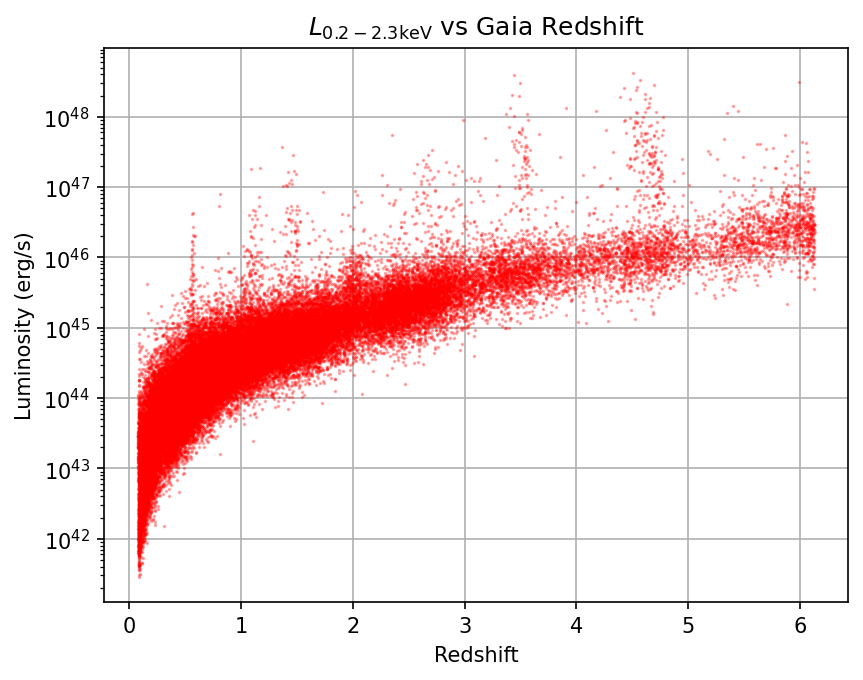

In [13]:
plt.figure(dpi=150)
plt.scatter(matched_quasars['GAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, c='r', zorder=10)
plt.grid(zorder= -10)
plt.yscale('log')
plt.ylabel("Luminosity (erg/s)")
plt.xlabel("Redshift")
plt.title(r'$L_{0.2-2.3\rm{keV}}$ vs Gaia Redshift')
plt.savefig("../Products/x-ray_luminosities_vs_gaia_z.png")
plt.show()


Clear spikes in luminosity at certain redshifts, so redshift values from gaia probably not overly reliable or these are not quasars?

Writing the matched table to a file.

In [14]:
matched_quasars.write("../Products/Tables/matched_quasars.csv", overwrite=True)

# Crossmatching purer sample

This is basically following the same process (and is also mostly copy-pasta from previous bit)

In [15]:
gaia_coords = SkyCoord(ra=purer_gaia_sources['ra']*u.deg, dec=purer_gaia_sources['dec']*u.deg)
eRASS_coords = SkyCoord(ra=eRASS_sources['RA'], dec=eRASS_sources['DEC']) # eRASS data has units on it coordinates 😀

ids, d2d, d3d = eRASS_coords.match_to_catalog_sky(gaia_coords)

max_separation = u.Quantity(3,"arcsec")
separation_condition = d2d < max_separation

print(np.count_nonzero(separation_condition), "matches within 3 arcsec")


14587 matches within 3 arcsec


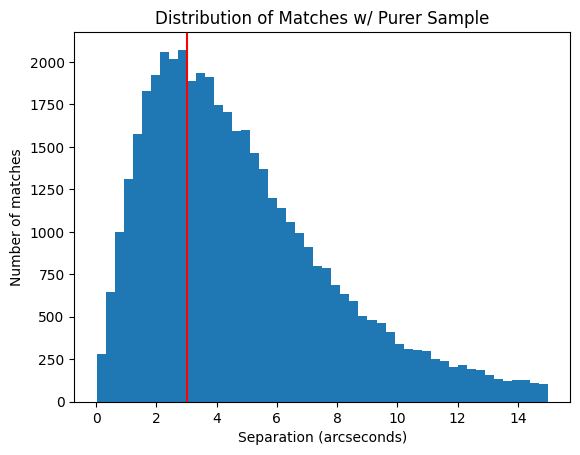

In [16]:
plt.figure(dpi=100)
counts, bins, *_ = plt.hist(d2d.arcsec[d2d < u.Quantity(15, "arcsec")], bins=50)

plt.axvline(max_separation.value, c='r')
plt.ylabel("Number of matches")
plt.xlabel("Separation (arcseconds)")
plt.title("Distribution of Matches w/ Purer Sample")
plt.savefig("../Products/purer_matching_distribution.png")
plt.show()


In [17]:
matched_quasars_purer = eRASS_sources[separation_condition]
matched_quasars_purer['GAIA_source_id'] = purer_gaia_sources[ids[separation_condition]]['source_id']
matched_quasars_purer['GAIA_redshift'] = purer_gaia_sources[ids[separation_condition]]['redshift_qsoc']

print(len(matched_quasars_purer), "matched x-ray quasars.")
matched_quasars_purer[0:3]


14587 matched x-ray quasars.


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,GAIA_source_id,GAIA_redshift
,,deg,deg,,arcsec,erg / (s cm2),,
bytes23,int64,float64,float64,float32,float32,float32,int64,float64
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693,0.0,1.5508955e-12,2317512508372225024,0.14347011
1eRASS J015721.4-161420,102910500003,29.33957853410675,-16.23894002590743,0.9500018,0.0,1.5089055e-12,5141931621251439360,0.14679268
1eRASS J020457.6-170120,103010800003,31.240058066010775,-17.022440181196895,0.97199553,0.0,1.1475187e-12,5144596631278605568,1.7396051


In [18]:
quasar_luminosity_distance = cosmo.luminosity_distance(z = matched_quasars_purer['GAIA_redshift'])
quasar_luminosities = 4*np.pi*(quasar_luminosity_distance**2)*matched_quasars_purer['ML_FLUX_1']
# convert units
quasar_luminosities = quasar_luminosities.to("erg/s")


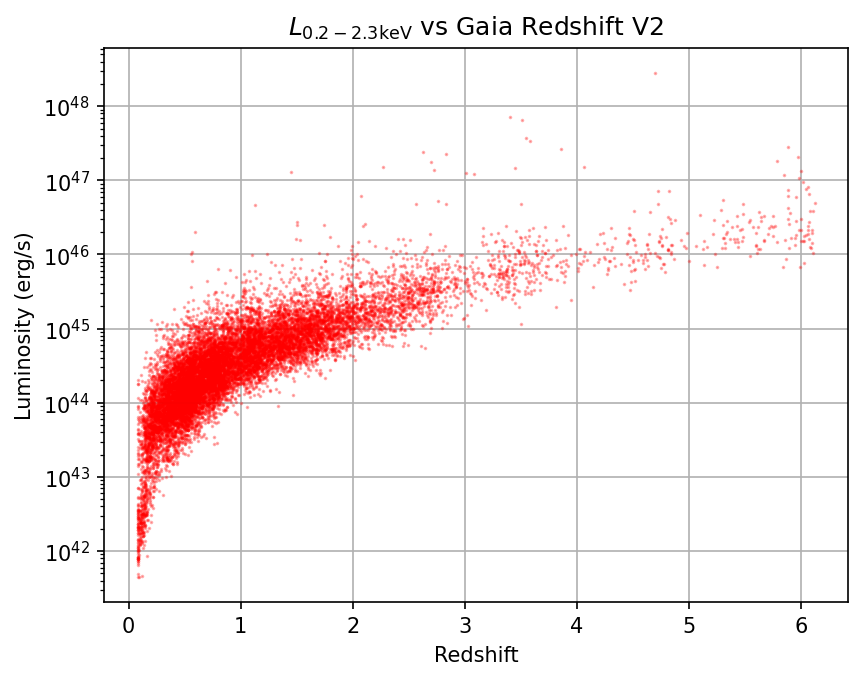

In [19]:
plt.figure(dpi=150)
plt.scatter(matched_quasars_purer['GAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, c='r', zorder=10)
plt.grid(zorder= -10)
plt.yscale('log')
plt.ylabel("Luminosity (erg/s)")
plt.xlabel("Redshift")
plt.title(r'$L_{0.2-2.3\rm{keV}}$ vs Gaia Redshift V2')
plt.savefig("../Products/purer_x-ray_luminosities_vs_gaia_z.png")
plt.show()


# Crossmatching with Quaia

This is, once again, basically the same as previous sections and so mostly copy-pasta again.

matching

In [20]:
quaia_coords = SkyCoord(ra=quaia_sources['ra'], dec=quaia_sources['dec'])# quaia data also has units 😀
eRASS_coords = SkyCoord(ra=eRASS_sources['RA'], dec=eRASS_sources['DEC']) # eRASS data has units on it coordinates 😀

ids, d2d, d3d = eRASS_coords.match_to_catalog_sky(quaia_coords)

max_separation = u.Quantity(3,"arcsec")
separation_condition = d2d < max_separation

print(np.count_nonzero(separation_condition), "matches within 3 arcsec")


40511 matches within 3 arcsec


### Random matching

Create function to randomly decided whether I add or subtract a random value <br>
I think this function could be one of the reasons this is so slow

In [21]:
def random_gen_thing(rng, length):
    # Generates random array of either +1 or -1 so i can randomly add or subtract a offset
    random_array = np.round(rng.uniform(0, 1, length)).astype(int)
    random_array = random_array - (~random_array.astype(bool)).astype(int)
    return random_array

Random shift every Quaia ra and dec coord by a value between 10 to 20 arcsecs <br>
Then match these to eRASS source using astropy <br>
Create histogram for distribution of these sources and add counts to array for computing average over `'50'` loops

In [22]:
bins = 50
rng = np.random.default_rng(seed=113)

average_rand_counts = np.zeros(bins)

# i = 0
length = len(quaia_sources)

# match to randomized coords 50 times

for i in range(50):
    ra_random = rng.uniform(10, 20, length) * random_gen_thing(rng, length)
    dec_random = rng.uniform(10, 20, length) * random_gen_thing(rng, length)
    random_coords = SkyCoord(
        ra = (quaia_sources['ra'] + u.Quantity(ra_random, 'arcsec')),
        dec = (quaia_sources['dec'] + u.Quantity(dec_random, 'arcsec'))
        )
    
    idx_rand, d2d_rand, d3d_rand = random_coords.match_to_catalog_sky(eRASS_coords)

    counts_rand, bins_rand = np.histogram(d2d_rand.arcsec[d2d_rand < u.Quantity(15, 'arcsec')], bins=bins)

    average_rand_counts += counts_rand

average_rand_counts /= (i+1)
    


Plotting matches distribution

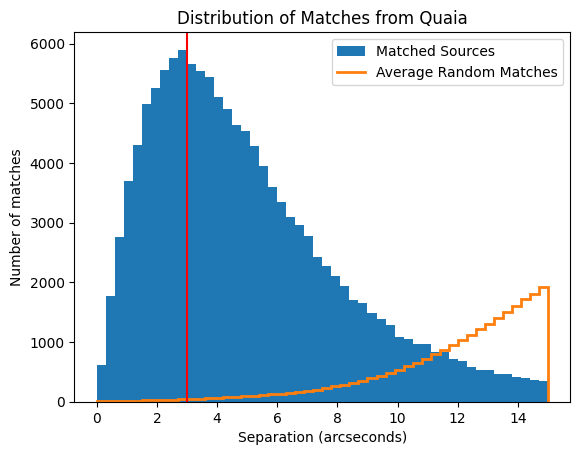

 207.72 Random matches within 3 arcsecs


In [23]:
plt.figure(dpi=100)
counts, bins, *_ = plt.hist(d2d.arcsec[d2d < u.Quantity(15, "arcsec")], bins=bins, label="Matched Sources")
plt.stairs(average_rand_counts, bins, linewidth=2, label="Average Random Matches")

plt.axvline(max_separation.value, c='r')
plt.ylabel("Number of matches")
plt.xlabel("Separation (arcseconds)")
plt.title("Distribution of Matches from Quaia")
plt.legend()
plt.savefig("../Products/quaia_matching_distribution.png", dpi=100)
plt.show()

print(f"{sum(average_rand_counts[:10]): 5g} Random matches within 3 arcsecs")
# print(f"{sum(counts[0:10]): 5g}")

Conclusion, Random matches are pretty negligible

Creating new matched Table

In [24]:
matched_quaia = eRASS_sources[separation_condition]
matched_quaia['QUAIA_source_id'] = quaia_sources[ids[separation_condition]]['source_id']
matched_quaia['QUAIA_redshift'] = quaia_sources[ids[separation_condition]]['redshift_quaia']
matched_quaia['QUAIA_redshift_err'] = quaia_sources[ids[separation_condition]]['redshift_quaia_err']

print(len(matched_quaia), "matched x-ray quaia quasars.")
matched_quaia[0:3]

40511 matched x-ray quaia quasars.


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err
,,deg,deg,,arcsec,erg / (s cm2),,,
bytes23,int64,float64,float64,float32,float32,float32,int64,float64,float64
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693,0.0,1.5508955e-12,2317512508372225024,0.282,0.1090472537279129
1eRASS J012338.1-231059,102111400001,20.90908484230626,-23.183134713205,1.2023203,0.0,1.1919693e-11,5041410282510663168,0.39622849225997925,0.13338495750904084
1eRASS J020037.2-164905,103010800001,30.155090369271388,-16.818333184496638,0.67306,0.0,2.4859784e-12,5141673064220360320,0.3344,0.14063352643013


Calculating Luminosities

In [25]:
quasar_luminosity_distance = cosmo.luminosity_distance(z = matched_quaia['QUAIA_redshift'])
quasar_luminosities = 4*np.pi*(quasar_luminosity_distance**2)*matched_quaia['ML_FLUX_1']
# convert units
quasar_luminosities = quasar_luminosities.to("erg/s")

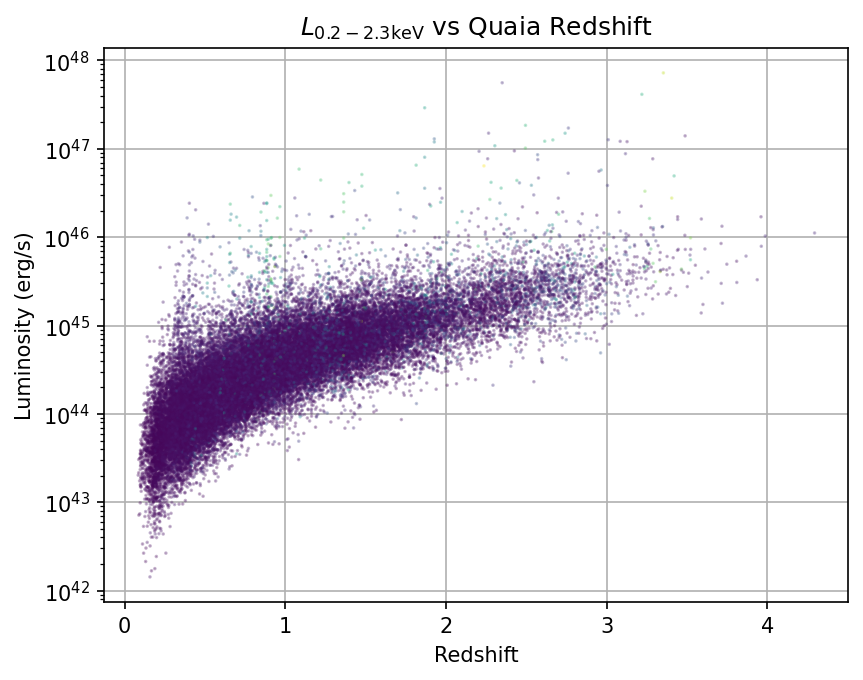

In [26]:
plt.figure(dpi=150)
plt.scatter(matched_quaia['QUAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, c=matched_quaia['QUAIA_redshift_err'], zorder=10)
# plt.scatter(matched_quaia['QUAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, zorder=10)
plt.grid(zorder= -10)
plt.yscale('log')
plt.ylabel("Luminosity (erg/s)")
plt.xlabel("Redshift")
plt.title(r'$L_{0.2-2.3\rm{keV}}$ vs Quaia Redshift')
plt.savefig("../Products/x-ray_luminosities_vs_quaia_z.png")
plt.show()

In [27]:
matched_quaia.write("../Products/Tables/matched_quaia.csv", overwrite=True)

### Check with previous x-ray quasars from XCS main source list

In [28]:
xcs_quasars = Table.read("../Data/xcs_quasars_matched.csv")
print(len(xcs_quasars))
xcs_quasars[0:3]


23472


#XCSNAME,XMM_OBSID,RA,DEC,CLASS,MASTERID,SOFTCOUNTS,SOFTCR,GAIA_ID,GAIA_Z
str25,int64,float64,float64,str5,int64,float64,float64,int64,float64
XMMXCS J002557.7+103226.2,1930101,6.4907381,10.540638,Point,160,50.320406,0.00086477257,2754107612026283776,2.5827482
XMMXCS J002618.0+103824.0,1930101,6.5750951,10.640023,Point,169,241.62605,0.0025772377,2754131977376370304,2.8926463
XMMXCS J002618.5+105020.2,1930101,6.5772808,10.838969,Point,190,934.92518,0.019290543,2754148843711930368,0.48003244


Create array of booleans indicating if 

In [29]:
is_in_xcs = np.isin(matched_quaia["QUAIA_source_id"], xcs_quasars["GAIA_ID"].astype(np.uint64))
print(np.count_nonzero(is_in_xcs), "Sources in XCS")
# print(len(is_in_xcs), "Sources in XCS")


812 Sources in XCS


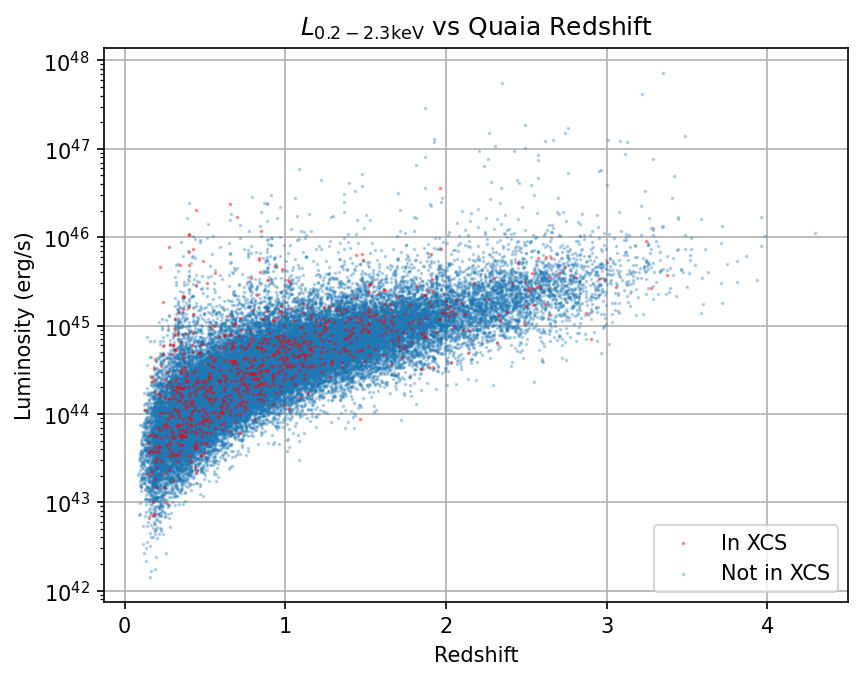

In [30]:
plt.figure(dpi=150)
# plt.scatter(matched_quaia['QUAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, c=matched_quaia['QUAIA_redshift_err'], zorder=10)
# plt.scatter(matched_quaia['QUAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, zorder=10)
plt.scatter(matched_quaia['QUAIA_redshift'][is_in_xcs], quasar_luminosities[is_in_xcs],s=0.5, alpha=0.4, zorder=10, c='r',label="In XCS")
plt.scatter(matched_quaia['QUAIA_redshift'][~is_in_xcs], quasar_luminosities[~is_in_xcs],s=0.5, alpha=0.3, zorder=9,label="Not in XCS")

plt.grid(zorder= -10)
plt.yscale('log')
plt.ylabel("Luminosity (erg/s)")
plt.xlabel("Redshift")
plt.title(r'$L_{0.2-2.3\rm{keV}}$ vs Quaia Redshift')
plt.legend(loc="lower right")
plt.savefig("../Products/x-ray_luminosities_vs_quaia_z_xcs_cmp.png")
plt.show()